In [23]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# 2. Data

Data that will be used to solve the problem:

1. Toronto neighborhood data 

scraped from a Wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

2. a csv file that has the geographical coordinates of each postal code: https://cocl.us/Geospatial_data

3. Foursquare location data, with latitude and longitude coordinates of each neighborhood.

4. Foursquare API to explore neighborhoods in Toronto.

For the Toronto neighborhood data, the data that we use is collected from a Wikipedia page, which provides all the information we need to explore and cluster the neighborhoods in Toronto.

### data wrangling

* The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood.

* Only process the cells that have an assigned borough. Ignore cells with a borough that is **Not assigned**.

* More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that **M5A** is listed twice and has two neighborhoods: **Harbourfront** and **Regent Park**. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

* If a cell has a borough but a **Not assigned** neighborhood, then the neighborhood will be the same as the borough.

In [2]:
import pandas as pd

data = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
df=data[0]

# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned
df.drop(df[df['Borough']=="Not assigned"].index,axis=0, inplace=True)
df1 = df.reset_index(drop=True)

# More than one neighborhood can exist in one postal code area
df2=df1.groupby("Postal Code").agg(lambda x:','.join(x))

# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough

df2.loc[df2['Neighbourhood']=="Not assigned",'Neighbourhood']=df2.loc[df2['Neighbourhood']=="Not assigned",'Borough']
df3 = df2.reset_index()
df3.rename(columns={'Postal Code': 'PostalCode', 'Neighbourhood': 'Neighborhood'}, inplace=True)

df3.head(12)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


### Get the geographical coordinates of the neighborhoods 

First, we built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name. Then, we use a csv file that has the geographical coordinates of each postal code: https://cocl.us/Geospatial_data

In [3]:
df_geo_coor = pd.read_csv("https://cocl.us/Geospatial_data")
df_geo_coor.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)

df_toronto = pd.merge(df3, df_geo_coor, on = 'PostalCode')
print(df_toronto.shape)
df_toronto.head(12)

(103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [4]:
# boroughs that contain the word Toronto
toronto_data = df_toronto.drop(['PostalCode'], axis = 1)
print(toronto_data.shape)
toronto_data.head()

(103, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


### use the Foursquare API to explore neighborhoods in Toronto

In [5]:
# Define Foursquare Credentials and Version
CLIENT_ID = 'HCIVIDXNSDTQLK22TG50GUXXJYWHKTIXMETS2A4ZWSTWRYND' # your Foursquare ID
CLIENT_SECRET = 'TCW3UN3CEKALRFZEBKFOXQKSITG3C5IIXINIQODLIRYNBUU0' # your Foursquare Secret
VERSION = '20200731' # Foursquare API version

In [6]:
# define a function for getting the top 100 nearby venues with a radius of 1 km

def get_venues(lat, lng, radius=1000, LIMIT=100):
    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()
        venue_data=results["response"]['groups'][0]['items']
        venues_list=[]
        
        for v in venue_data:
        # return only relevant information for each nearby venue
            try:
                venue_id=v['venue']['id']
                venue_name=v['venue']['name']
                venue_category=v['venue']['categories'][0]['name']
                venues_list.append([venue_id, venue_name, venue_category])
            except KeyError:
                pass

        column_names=['ID','Name','Category']
        df = pd.DataFrame(venues_list, columns=column_names)
    
        return(df)

In [9]:
# we get all the Chinese restaurant in Toronto

column_names=['Borough', 'Neighborhood', 'ID','Name']
cn_rest_to=pd.DataFrame(columns=column_names)
count=1
for row in toronto_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    cn_resturants=venues[venues['Category']=='Chinese Restaurant']  
    for resturant_detail in cn_resturants.values.tolist():
        id, name , category=resturant_detail
        cn_rest_to = cn_rest_to.append({'Borough': Borough,
                                        'Neighborhood': Neighborhood, 
                                        'ID': id,
                                        'Name' : name}, ignore_index=True)
    count+=1

In [19]:
print(cn_rest_to.shape)
cn_rest_to.head()

(49, 4)


,Borough,Neighborhood,ID,Name
0,Scarborough,"Malvern, Rouge",4c706524df6b8cfab244b84d,Charley's Exotic Cuisine
1,Scarborough,"Guildwood, Morningside, West Hill",4c85aa5bee6fef3b1d1d3e5c,Peking Garden Restaurant
2,Scarborough,Woburn,4b64765ff964a52028b52ae3,Lucky Hakka
3,Scarborough,Cedarbrae,54a6ea76498ebc906c8c3652,Hakka Legend
4,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",4b6475def964a520f9b42ae3,Chung Moi


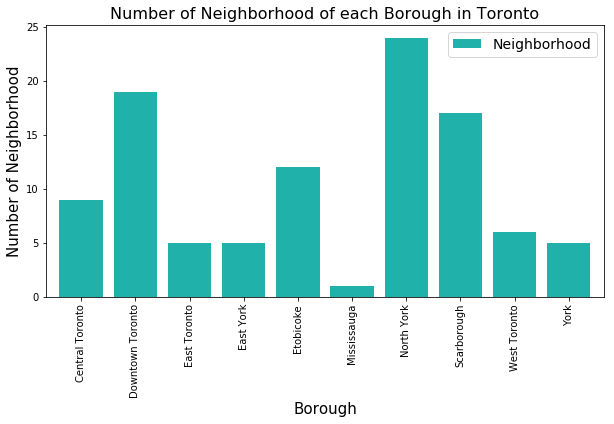

In [40]:
# data visualisation for Preliminary analysis
toronto_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar',
                                                            figsize=(10,5),
                                                            width=0.8,
                                                            color='#20B2AA')
                                                    
plt.title('Number of Neighborhood of each Borough in Toronto', fontsize=16)
plt.legend(fontsize=14)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Number of Neighborhood', fontsize=15)

plt.show()

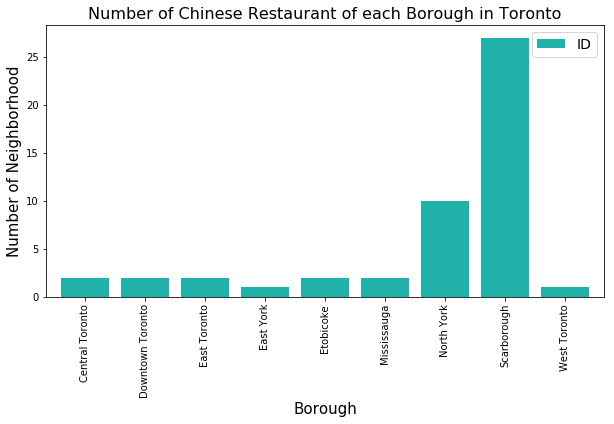

In [41]:
cn_rest_to.groupby('Borough')['ID'].count().plot(kind='bar',
                                                 figsize=(10,5),
                                                 width=0.8,
                                                 color='#20B2AA')
plt.title('Number of Chinese Restaurant of each Borough in Toronto', fontsize=16)
plt.legend(fontsize=14)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Number of Neighborhood', fontsize=15)

plt.show()

From the above barplot, we can see that Scarbrough has the largest number of Chinese restaurants. And North York ranks the second place.

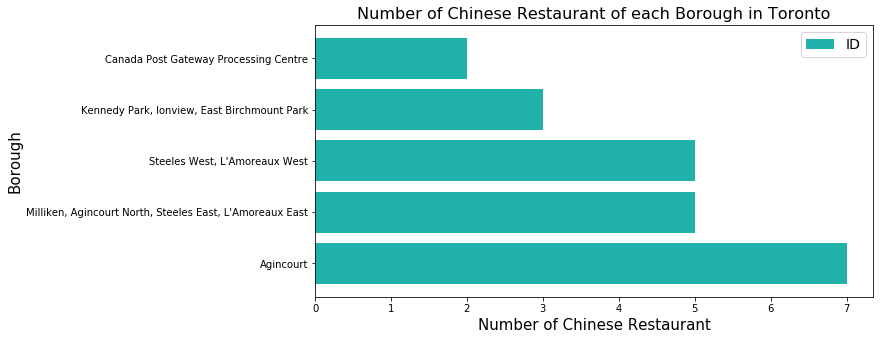

In [48]:
cn_rest_to.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='barh',
                                                 figsize=(10,5),
                                                 width=0.8,
                                                 color='#20B2AA')
plt.title('Number of Chinese Restaurant of each Borough in Toronto', fontsize=16)
plt.legend(fontsize=14)
plt.ylabel('Borough', fontsize = 15)
plt.xlabel('Number of Chinese Restaurant', fontsize=15)

plt.show()

From above, we can see that Agincourt borough has the largest number of Chinese restaurant, which is in Scarborough.